In [8]:
from sample_data.Utility import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

In [10]:
# Turn .csv files into pandas DataFrame's
import pandas as pd
train_df = pd.read_csv("sample_data/train.csv")
test_df = pd.read_csv("sample_data/test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [11]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [12]:
# The test data doesn't have a target (that's what we'd try to predict)
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [13]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [14]:
# How many samples total?
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


In [15]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 1 (real disaster)
Text:
Reminder: Mass murderer and white supremacist Anders Breivik was also unsurprisingly an anti-feminist.
http://t.co/1lXnJVl8TR

---

Target: 0 (not real disaster)
Text:
do he love me do he love me not I ain't a playa I just crush a lot

---

Target: 1 (real disaster)
Text:
Julian Knight - @SCVSupremeCourt dismisses mass murderer's attempt to increase prisoner pay. Challenged quantum of 5% increase 2013.

---

Target: 1 (real disaster)
Text:
Savings and sewing in Guatemala: Savings and sewing in Guatemala. When a natural disaster hit seamstress Elvia...  http://t.co/jdx9OX2kIk

---

Target: 0 (not real disaster)
Text:
Man Cam just demolished his plate. His ass was hungry

---



In [16]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibilit

In [17]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [18]:
# View the first 10 training sentences and their labels
train_sentences[:10], train_labels[:10]


(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

In [21]:
# Find average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [22]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [23]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [24]:
# Create sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [25]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
Imagine getting flattened by Kurt Zouma      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[1514,  209,  485,   18,    1, 2589,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [26]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [27]:
#Cretae an embedding layer
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1")

embedding

In [28]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
He was only .4 of a second faster than me and I overtook him twice (then crashed) tru luv &lt;3 &lt;3      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.04873523, -0.03417825, -0.04730256, ..., -0.0232558 ,
         -0.0072148 ,  0.04929205],
        [ 0.01964957, -0.02179741,  0.01504103, ...,  0.00772084,
          0.02891706,  0.04128448],
        [-0.0069524 , -0.03565482,  0.04348854, ..., -0.00826377,
         -0.04133787, -0.04252011],
        ...,
        [ 0.03243874, -0.02120315, -0.04538952, ..., -0.04641891,
         -0.00503343,  0.02925606],
        [ 0.03669825,  0.0374153 ,  0.04890211, ...,  0.01360024,
         -0.00616496, -0.01060511],
        [-0.01856614,  0.03471569, -0.0463549 , ...,  0.02103858,
         -0.04284692, -0.02380608]]], dtype=float32)>

#Baseline Model

In [29]:
### Create a baseline Model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [30]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [31]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [32]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [33]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

#Simple dense model

In [35]:
###Model 1
# Create tensorboard callback (need to create a new one for each model)
from sample_data.Utility import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [36]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [37]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [38]:
# Get a summary of the model
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [39]:
# Fit the model
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20230720-092054
Epoch 1/5
215/215 [==============================] - 8s 28ms/step - loss: 0.6093 - accuracy: 0.6910 - val_loss: 0.5359 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 4s 20ms/step - loss: 0.4409 - accuracy: 0.8206 - val_loss: 0.4689 - val_accuracy: 0.7874
Epoch 3/5
215/215 [==============================] - 5s 25ms/step - loss: 0.3460 - accuracy: 0.8619 - val_loss: 0.4587 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 4s 20ms/step - loss: 0.2845 - accuracy: 0.8924 - val_loss: 0.4638 - val_accuracy: 0.7900
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.2376 - accuracy: 0.9118 - val_loss: 0.4763 - val_accuracy: 0.7874


In [40]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.4763 - accuracy: 0.7874


[0.4762992560863495, 0.787401556968689]

In [41]:
# Make predictions (these come back in the form of probabilities)
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10] # only print out the first 10 prediction probabilities

24/24 [==============================] - 1s 6ms/step


array([[0.4242458 ],
       [0.74537   ],
       [0.99792504],
       [0.10865718],
       [0.09897235],
       [0.934209  ],
       [0.912776  ],
       [0.9928678 ],
       [0.9710315 ],
       [0.26415375]], dtype=float32)

In [42]:
# Turn prediction probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [43]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.74015748031496,
 'precision': 0.7914920592553047,
 'recall': 0.7874015748031497,
 'f1': 0.7846966492209201}

In [44]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results,
                                new_model_results=model_1_results)

Baseline accuracy: 79.27, New accuracy: 78.74, Difference: -0.52
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.79, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.00


#LSTM

In [45]:
###Model2
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [46]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [47]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [48]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20230720-092732
Epoch 1/5
215/215 [==============================] - 13s 46ms/step - loss: 0.5122 - accuracy: 0.7432 - val_loss: 0.4585 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 9s 43ms/step - loss: 0.3183 - accuracy: 0.8730 - val_loss: 0.5218 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 9s 42ms/step - loss: 0.2189 - accuracy: 0.9180 - val_loss: 0.5834 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 10s 44ms/step - loss: 0.1524 - accuracy: 0.9451 - val_loss: 0.6270 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 10s 49ms/step - loss: 0.1065 - accuracy: 0.9622 - val_loss: 0.8691 - val_accuracy: 0.7572


In [49]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10] # view the first 10

24/24 [==============================] - 1s 12ms/step


((762, 1),
 array([[0.01617398],
        [0.7986331 ],
        [0.9994739 ],
        [0.05396042],
        [0.00375327],
        [0.99943626],
        [0.978044  ],
        [0.9996552 ],
        [0.9994829 ],
        [0.26900095]], dtype=float32))

In [50]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [51]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 75.7217847769029,
 'precision': 0.7574646046920478,
 'recall': 0.7572178477690289,
 'f1': 0.7557133417830907}

In [52]:
# Compare model 2 to baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 79.27, New accuracy: 75.72, Difference: -3.54
Baseline precision: 0.81, New precision: 0.76, Difference: -0.05
Baseline recall: 0.79, New recall: 0.76, Difference: -0.04
Baseline f1: 0.79, New f1: 0.76, Difference: -0.03


#GRU

In [53]:
### Model 3
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [54]:
# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [55]:
# Get a summary of the GRU model
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [56]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20230720-093529
Epoch 1/5
215/215 [==============================] - 12s 43ms/step - loss: 0.5250 - accuracy: 0.7304 - val_loss: 0.4575 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 8s 36ms/step - loss: 0.3175 - accuracy: 0.8702 - val_loss: 0.4947 - val_accuracy: 0.7769
Epoch 3/5
215/215 [==============================] - 8s 39ms/step - loss: 0.2168 - accuracy: 0.9194 - val_loss: 0.5637 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 9s 40ms/step - loss: 0.1536 - accuracy: 0.9466 - val_loss: 0.6290 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 7s 35ms/step - loss: 0.1179 - accuracy: 0.9607 - val_loss: 0.6031 - val_accuracy: 0.7690


In [57]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

24/24 [==============================] - 1s 9ms/step


((762, 1),
 array([[0.31225616],
        [0.92874575],
        [0.9965498 ],
        [0.12866001],
        [0.01376418],
        [0.987567  ],
        [0.7076406 ],
        [0.997065  ],
        [0.9957705 ],
        [0.3520242 ]], dtype=float32))

In [58]:
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [59]:
# Calcuate model_3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 76.9028871391076,
 'precision': 0.7691242349168363,
 'recall': 0.7690288713910761,
 'f1': 0.7678647757387915}

In [60]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.27, New accuracy: 76.90, Difference: -2.36
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


#Bi-Directional RNN


In [61]:
###Model 4
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [62]:
# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [63]:
# Get a summary of our bidirectional model
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [64]:
# Fit the model (takes longer because of the bidirectional layers)
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20230720-093854
Epoch 1/5
215/215 [==============================] - 17s 55ms/step - loss: 0.5082 - accuracy: 0.7450 - val_loss: 0.4584 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 10s 48ms/step - loss: 0.3125 - accuracy: 0.8726 - val_loss: 0.5259 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 11s 49ms/step - loss: 0.2131 - accuracy: 0.9167 - val_loss: 0.5700 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 9s 43ms/step - loss: 0.1462 - accuracy: 0.9510 - val_loss: 0.6551 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 10s 47ms/step - loss: 0.1032 - accuracy: 0.9626 - val_loss: 0.7180 - val_accuracy: 0.7572


In [65]:
# Make predictions with bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 2s 9ms/step


array([[0.03427869],
       [0.92729616],
       [0.9997414 ],
       [0.24137555],
       [0.00484153],
       [0.9985301 ],
       [0.98748964],
       [0.99983126],
       [0.9997825 ],
       [0.3369998 ]], dtype=float32)

In [66]:
# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [67]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 75.7217847769029,
 'precision': 0.7567817252856622,
 'recall': 0.7572178477690289,
 'f1': 0.756704019080563}

In [68]:
# Check to see how the bidirectional model performs against the baseline
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.27, New accuracy: 75.72, Difference: -3.54
Baseline precision: 0.81, New precision: 0.76, Difference: -0.05
Baseline recall: 0.79, New recall: 0.76, Difference: -0.04
Baseline f1: 0.79, New f1: 0.76, Difference: -0.03


In [70]:
### Check all results
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.740157,0.791492,0.787402,0.784697
lstm,75.721785,0.757465,0.757218,0.755713
gru,76.902887,0.769124,0.769029,0.767865
bidirectional,75.721785,0.756782,0.757218,0.756704


In [71]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

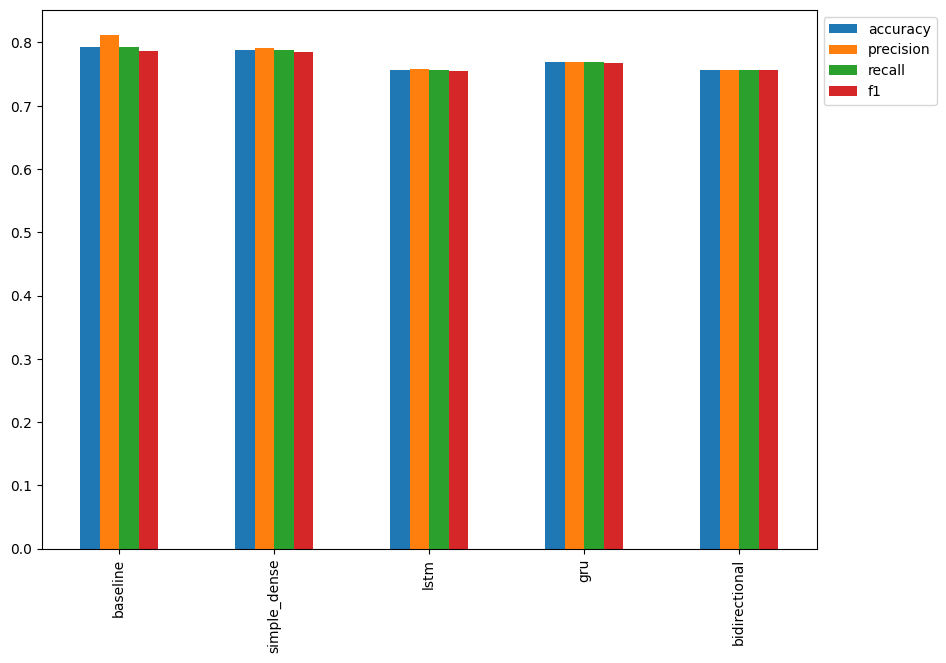

In [72]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

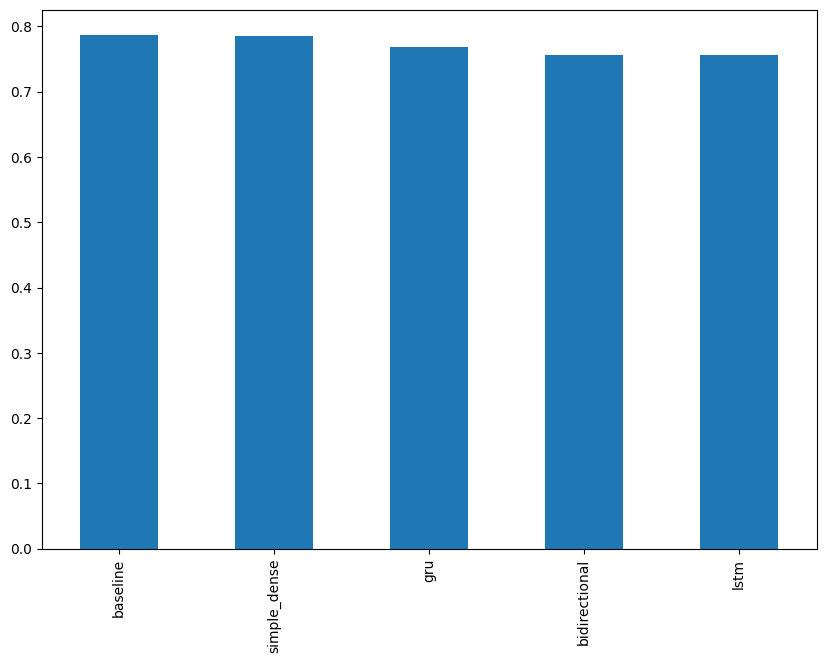

In [73]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));